In [1]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection  import train_test_split

from tools.utils import *
from tools.het_networks import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 7
num_layers = 2
intra_aggr='mean'
inter_aggr='sum'
dropout = 0.5

# Training
batch_size = 32
epochs = 30
lr = 1e-4
maxlr = 3e-4

# Preprocessing

In [3]:
reset_seeds(seed, device)

# CUDA reproducibility
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Load dataset
het_dataset = torch.load('data/PSCDB/het_pscdb_graphs.pt', weights_only=False)
len(het_dataset)

856

In [5]:
def normalize_and_recompute_displacement(hetero_data):
    hetero_data = hetero_data.clone()
    for node_type in hetero_data.node_types:
        node_data = hetero_data[node_type]
        if hasattr(node_data, 'x') and node_data.x is not None:
            x = node_data.x
            if x.size(1) >= 6:
                # Normalize free and bound coordinates
                coords = x[:, :6]
                mean = coords.mean(dim=0)
                std = coords.std(dim=0, unbiased=False)
                std[std == 0] = 1.0
                normalized_coords = (coords - mean) / std
                x[:, :6] = normalized_coords
                # Recompute displacement as (bound_normalized - free_normalized)
                free_normalized = normalized_coords[:, :3]
                bound_normalized = normalized_coords[:, 3:6]
                displacement_normalized = bound_normalized - free_normalized
                x[:, 6:9] = displacement_normalized

                hetero_data[node_type].x = x
    return hetero_data

# Normalize features
normalized_het_dataset = [normalize_and_recompute_displacement(het_data) for het_data in het_dataset]

/tmp/ipykernel_74333/740165721.py:11: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = coords.std(dim=0, unbiased=False)


In [6]:
# Create splits
labels = [data.y.item() for data in normalized_het_dataset]

train_set, temp_set = train_test_split(
    normalized_het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)

# HeteroGNN_GraphConv

In [8]:
train_loader = get_train_loader(seed, train_set, batch_size)
next(iter(train_loader))

HeteroDataBatch(
  y=[32],
  A={
    x=[639, 9],
    batch=[639],
    ptr=[33],
  },
  C={
    x=[108, 9],
    batch=[108],
    ptr=[33],
  },
  D={
    x=[570, 9],
    batch=[570],
    ptr=[33],
  },
  E={
    x=[647, 9],
    batch=[647],
    ptr=[33],
  },
  F={
    x=[438, 9],
    batch=[438],
    ptr=[33],
  },
  G={
    x=[648, 9],
    batch=[648],
    ptr=[33],
  },
  H={
    x=[194, 9],
    batch=[194],
    ptr=[33],
  },
  I={
    x=[667, 9],
    batch=[667],
    ptr=[33],
  },
  K={
    x=[594, 9],
    batch=[594],
    ptr=[33],
  },
  L={
    x=[872, 9],
    batch=[872],
    ptr=[33],
  },
  M={
    x=[162, 9],
    batch=[162],
    ptr=[33],
  },
  N={
    x=[455, 9],
    batch=[455],
    ptr=[33],
  },
  P={
    x=[422, 9],
    batch=[422],
    ptr=[33],
  },
  Q={
    x=[314, 9],
    batch=[314],
    ptr=[33],
  },
  R={
    x=[492, 9],
    batch=[492],
    ptr=[33],
  },
  S={
    x=[555, 9],
    batch=[555],
    ptr=[33],
  },
  T={
    x=[462, 9],
    batch=[462],
    pt

In [9]:
experiment_name = f"PSCDB-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_GraphConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (D): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (E): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (F): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (G): MLP(
      (layers): ModuleList(
    

In [10]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [11]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.9295 | Validation Loss: 1.9129
Train Acc: 0.2154 | Validation Acc: 0.3438
Train F1: 0.0894 | Validation F1: 0.0731

Epoch 2/30
Train Loss: 1.8580 | Validation Loss: 1.8487
Train Acc: 0.3456 | Validation Acc: 0.3438
Train F1: 0.0735 | Validation F1: 0.0731

Epoch 3/30
Train Loss: 1.8097 | Validation Loss: 1.8139
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 4/30
Train Loss: 1.8035 | Validation Loss: 1.8160
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 5/30
Train Loss: 1.8067 | Validation Loss: 1.8268
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 6/30
Train Loss: 1.8051 | Validation Loss: 1.8092
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 7/30
Train Loss: 1.8090 | Validation Loss: 1.8211
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 8/30
Tr

KeyboardInterrupt: 

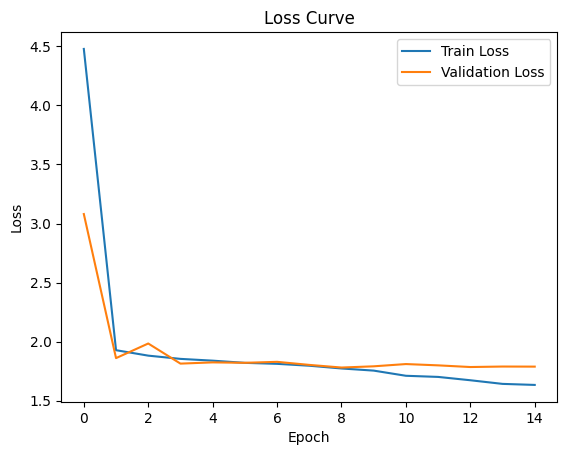

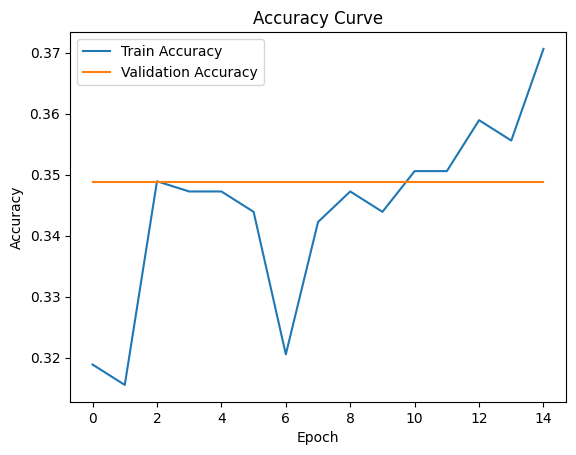

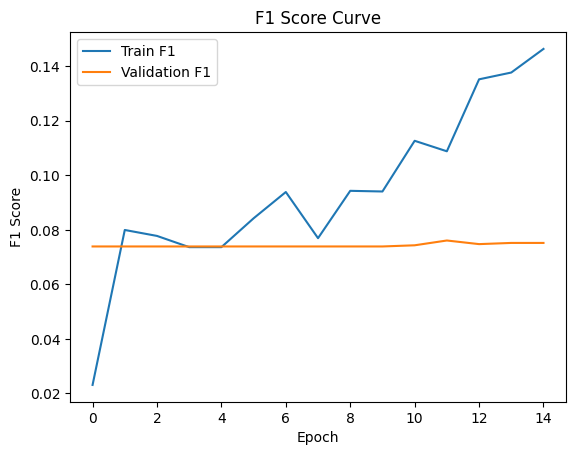

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,4.4786,3.0805,0.3189,0.3488,0.0231,0.0739
1,2,1.9277,1.8606,0.3155,0.3488,0.0799,0.0739
2,3,1.8815,1.9843,0.3489,0.3488,0.0778,0.0739
3,4,1.8541,1.8140,0.3472,0.3488,0.0736,0.0739
4,5,1.8390,1.8244,0.3472,0.3488,0.0736,0.0739
5,6,1.8204,1.8207,0.3439,0.3488,0.0842,0.0739
6,7,1.8121,1.8290,0.3205,0.3488,0.0939,0.0739
7,8,1.7961,1.8031,0.3422,0.3488,0.0769,0.0739
8,9,1.7729,1.7808,0.3472,0.3488,0.0943,0.0739
9,10,1.7547,1.7911,0.3439,0.3488,0.0941,0.0739


In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HeteroGNN_SAGEConv

In [ ]:
experiment_name = f"PSCDB-HeteroGNN_SAGEConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_SAGEConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HeteroGNN_SAGEConv(
  (node_emb_layers): ModuleDict(
    (A): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (C): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (D): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (E): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (F): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
    (G): MLP(
      (layers): ModuleList(
     

In [ ]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [ ]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

KeyboardInterrupt: 

In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HeteroGNN_GATConv

In [ ]:
experiment_name = f"PSCDB-HeteroGNN_GATConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GATConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

In [ ]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [ ]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

In [ ]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)